# Music Machine Learning - Latent models and clustering

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. Unsupervised learning and [clustering](#clustering).
2. Motivating the need for [latent variable](#latent) models.
2. Approaching the problem naïvely with the [k-Means](#kmeans) algorithm.

## Unsupervised learning and clustering

Up to now, we have dealt with *supervised* problems (classification, regression), which implies that we have *paired* data. This implies that we both have data examples $\{\mathbf{x} \in \mathbb{R}^{n}\}$ and their corresponding labels $\{\mathbf{y}_{i} \in \mathbb{R}^{n}\}$, and we are trying to find the function to link these two sets, or equivalently, the joint distribution $p(\mathbf{y} \vert \mathbf{x})$.

Now imagine that we only have access to $\{\mathbf{x} \in \mathbb{R}^{n}\}$ (a set of data without particular annotations). For instance, consider the following set

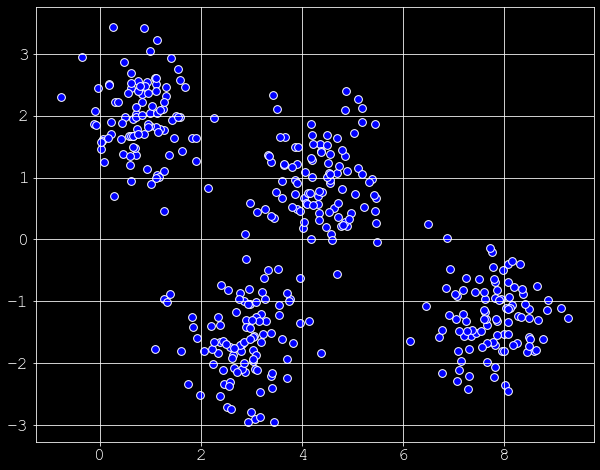

In [2]:
from helper_plot import hdr_plot_style
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
hdr_plot_style();
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]; plt.figure(figsize=(10, 8));
plt.scatter(X[:, 0], X[:, 1], c='b', s=60, edgecolor='w'); plt.grid(True);

Here we can clearly see that there are some *clusters* underlying our data. This is a form of *hidden structure*, which we might want to model. This type of learning is called *unsupervised learning* (here specifically, clustering). We might want to model the complete distribution $\mathbf{x} \sim p(\mathbf{x})$. However, this might be very hard to define directly, as we know that there is some *hidden information* (data that we did not observe, such as the cluster identity here).

<a id='latent'> </a>
## Latent variable model

A latent variable is simply a variable that you never observe. In our previous example, these variables would be the *membership* of different points to clusters. These latent variables can be introduced to
- Quantify uncertainty
- Handle missing values

In our case, we introduce a latent variable $ z \in \mathbb{R}^{n}$, which corresponds to the cluster identity (or membership of each point to a given cluster), where $z_{i} = C_{k}$, and $C_k \in \mathbb{N}$ is a cluster identifier.

The goal of *unsupervised learning* and *latent variable models* is to model the joint distribution $p(\mathbf{x}, \mathbf{z})$, allowing to obtain $p(\mathbf{z}\vert\mathbf{x})$ (infering the hidden structure) and even $p(\mathbf{x} \vert \mathbf{z})$ (generating new examples from a given structure). Here, we will try to find the hidden *membership* of points to different clusters. We will start with a naïve and deterministic approach to this problem.


## Simple clustering : k-Means

We recall here the basic behind the k-Means algorithm. Given a set of observations ($\mathbf{x}_{1}$, $\mathbf{x}_{2}$, ..., $\mathbf{x}_{n}$), where each observation is a $d$-dimensional real vector, k-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_{1}, S_{2}, \cdots, S_{k}\}$ so as to minimize the within-cluster sum of squares (WCSS) (sum of distance functions of each point in the cluster to the $K$ center). In other words, its objective is to find:

$$
\begin{equation}
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2} 
\end{equation}
$$

Given an initial set of $k$ means $\{m_{1}^{(0)},\cdots,m_{k}^{(0)}\}$, the algorithm proceeds by alternating between two steps:

**Assignment step**: Assign each observation to the cluster whose mean yields the least within-cluster sum of squares (WCSS). Since the sum of squares is the squared Euclidean distance, this is intuitively the "nearest" mean. (Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means).

$$
S_{i}^{(t)}={\big \{}x_{p}:{\big \|}x_{p}-m_{i}^{(t)}{\big \|}^{2}\leq {\big \|}x_{p}-m_{j}^{(t)}{\big \|}^{2}\ \forall j,1\leq j\leq k{\big \}}
$$

where each $x_{p}$ is assigned to exactly one $S^{(t)}$, even if it could be assigned to two or more of them.  

**Update step**: Calculate the new means to be the centroids of the observations in the new clusters.

$$
m_{i}^{(t+1)}={\frac {1}{|S_{i}^{(t)}|}}\sum _{x_{j}\in S_{i}^{(t)}}x_{j}
$$

Since the arithmetic mean is a least-squares estimator, this also minimizes the within-cluster sum of squares (WCSS) objective.
The algorithm has converged when the assignments no longer change. Since both steps optimize the WCSS objective, and there only exists a finite number of such partitionings, the algorithm must converge to a (local) optimum. There is no guarantee that the global optimum is found using this algorithm.

### Observing k-Means with `scikit-learn`

As usual, we can first witness the effect of the kMeans algorithm using scikit. In the following code, we instantiate a `KMeans` object, which will allow to cluster our dataset of points.

C:\Users\audas\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


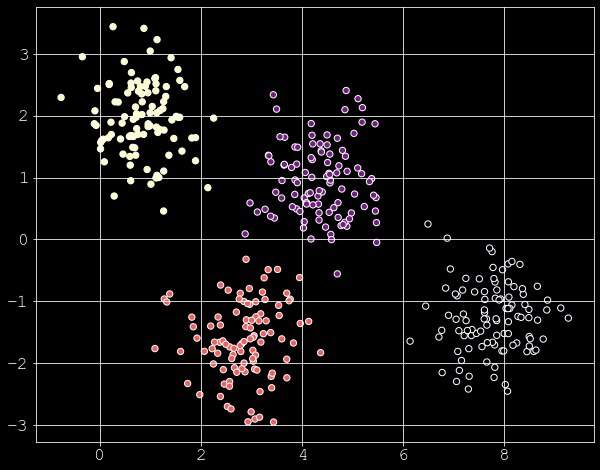

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=2, max_iter=10, n_init=1, init='random')
labels = kmeans.fit(X).predict(X)
plt.figure(figsize=(10,8)); plt.grid(True);
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', edgecolor='w');

plt.show()

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

### Implementing the k-Means algorithm


***

**Exercise**  

  1. Update the ''kmeans'' function to implement the clustering algorithm.
  2. Perform the plot using the spread function to display the results of clustering.
  3. Compare the results depending on the number of clusters (example are displayed below).
  4. What observations can you make on the quality of these clusters ?
  5. Compare your results with the `scikit` kMeans function.
  
***



In [5]:
import numpy as np

def kmeans(X, k):
    # X: d x n data matrix
    # k: number of seeds
    d,n=X.shape
    means=np.random.random((k,n))  
    
    dist=np.zeros((k,n))
    for i in range(k):
        dist[:,i]=np.sqrt(np.sum((X-means[i])**2))
    print(dist)
    
    return label

labels = kmeans(X.transpose(), 4)
plt.figure(figsize=(10,8)); plt.grid(True);
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', edgecolor='w');

TypeError: cannot unpack non-iterable int object

### Limitations of k-Means
One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    plt.figure(figsize=(10,8))
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', zorder=2, edgecolor='w')

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#AAAAAA', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

In [ ]:
import numpy as np
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

### Probabilistic clustering

We might imagine addressing the weaknesses of the *k*-means model. For example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a *probabilistic clustering*

- Usual clustering (kMeans) is done with a _hard_ decision threshold
    * Each point belongs to one cluster
    * For instance the basic k-Means algorithm
$$
C_{id} = f(\mathbf{x})
$$
- We might want to do probabilistic (soft) clustering
    * Each point belongs more or less to all clusters
    * Defines a probability of belonging
$$
p(C_{id} \vert x)
$$

Using probabilistic models has several interests, as it allows to provide finer evaluation of the clusters and their parameters. However, this will require to estimate both the parameters and cluster identity altogether. This is the goal of the **Expectation-Maximization** algorithm, that we will see in the next notebook.

## Bonus - Hierarchical clustering for audio thumbnailing

we will perform a simple shot at the problem of *audio structure discovery* and *audio thumbnailing*. The idea is to try to automatically infer the structure of a piece of music from its inner similarities in an *unsupervised way*. As previously, we will rely on our helper functions to import some audio dataset.

In [ ]:
from helper_data import import_dataset, compute_transforms, compute_features
class_path = 'data/music_speech'
# 0.1 - Import the classification dataset
data_struct = import_dataset(class_path, 'music-speech')
# 0.2 - Pre-process the audio to obtain spectral transforms 
data_struct = compute_transforms(data_struct)

We briefly recall here that the principle of *hierarchical agglomerative clustering* is to start with a singleton cluster, and clusters are iteratively merged until one single cluster remains. This results in a "cluster tree," which is also called dendrogram. The opposite approach (starting with one cluster and divide into clusters until only singleton clusters remain) is called *divisive hierarchical clustering*. The algorithm can be summarized via the following pseudocode

**1**: Compute a distance or similarity matrix.  
**2**: Each data point is represented as a singleton cluster.  
**3**: Repeat  
**4**: $\;\;$ Merge two closest clusters (e.g., based on distance between most similar or dissimilar members).  
**5**: $\;\;$ Update the distance (or similarity) matrix.  
**6**: Until one single cluster remains.  

As the algorithm is very easy to implement, we will learn how to apply it on more complex problems. The idea here is to use a *smoothed version* (time-wise) of audio tracks and try to find the *structure* of this music in an unsupervised way. Therefore, we will try to find similarities. To do so, rely on the documentation for the `cluster` and `linkage` function to find a way to perform hierarchical clustering on the set of spectrogram windows.

***

**Exercise**  
<div markdown="1">  

  1. Update the loop to perform hierarchical clustering.
  2. Evaluate different distances and tracks to see the effects.
  3. Implement your **own distance function** between spectrograms.
  4. Find a way to plug your distance matrix inside the clustering.
  
***

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.gridspec as gridspec
song_ex = 11
nbClusters = 20
# Extract the Constant-Q
curCQT = data_struct["spectrum_CQT"][song_ex];
nb_points = curCQT.shape[1]
# Perform a smoothed version
smooth_target = 200
smooth_wins = np.floor(nb_points / smooth_target) * 2
smoothCQT = np.zeros((smooth_target, curCQT.shape[0]))
# Prepare set of windows
first_win = smooth_wins / 2
last_win = nb_points - (smooth_wins / 2)
win_set = np.round(np.linspace(first_win, last_win, smooth_target))
win_starts = (win_set - first_win)
win_ends = win_starts + (smooth_wins)
# Go through the points
for t in range(smooth_target):
    winCQT = curCQT[:, int(win_starts[t]):int(win_ends[t])]
    smoothCQT[t, :] = np.mean(winCQT, axis=1)

######################
# YOUR CODE GOES HERE
######################
    
# Plot a stylish dendrogram
fig = plt.figure(figsize=(12,8))
gs1 = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 2])
gs1.update(wspace=0.025, hspace=0.01)
plt.subplot(gs1[0])
Rdict = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., p=nbClusters, count_sort=False, distance_sort=False, color_threshold=0.8)
ax = plt.gca()
ax.axis('off')
plt.subplot(gs1[1])
ax = plt.gca()
ax.axis('off')
for i in range(len(Rdict["ivl"])):
    plt.plot([i, Rdict["ivl"][i]], [1, 0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(gs1[2])
plt.imshow(np.flipud(smoothCQT.transpose()), aspect='auto')
plt.show()